In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
import numpy as np
import pandas as pd
from PIL import Image
import time

# Read in the images (and their file sizes)

In [2]:
filenames = glob('IR_images/*.jpg')
filenames.sort(key=lambda filename: os.stat(filename).st_mtime)
file_sizes = [os.path.getsize(filename) for filename in filenames]

# Iteratively label new images using a crude classifier & incorporate human-assigned labels
Making labeling as painless as possible is crucial. Also making the process repeatable without corrupting any hand-assigned labels, so that it's easy to add and review new training data.

In [3]:
if os.path.isfile('IR_is_open.csv'):
    df = pd.read_csv('IR_is_open.csv', index_col=0)
else:
    df = pd.DataFrame(columns=['file_size', 'is_open_guess', 'is_open_human', 'is_open'])
    
for filename, file_size in zip(filenames, file_sizes):
    df.loc[filename, 'file_size'] = int(file_size)

df.is_open_guess = (df.file_size >= 18000).astype(int)

df.is_open = df.is_open_human
index = df.is_open.isnull()
df.loc[ index, 'is_open'] = df.loc[ index, 'is_open_guess']

df.to_csv('IR_is_open.csv')

# Inspect the distribution of guessed labels

In [4]:
df.groupby('is_open_guess').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open_guess,
0,3096
1,1026


# Inspect the distribution of labels after incorporating human-assigned labels

In [5]:
df.groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open,
0.0,3015
1.0,1107


# Second stage (used after having a classifier the first time around)

In [6]:
df = pd.DataFrame(columns=['file_size', 'is_open_guess', 'is_open_human', 'is_open'])

for filename, file_size in zip(filenames, file_sizes):
    df.loc[filename, 'file_size'] = int(file_size)

subfolder = 'label/known/open/'
for file in glob('IR_images/'+subfolder+'*.jpg'):
    df.loc[ file.replace(subfolder, ''), 'is_open_human'] = 1

subfolder = 'label/known/closed/'
for file in glob('IR_images/'+subfolder+'*.jpg'):
    df.loc[ file.replace(subfolder, ''), 'is_open_human'] = 0

subfolder = 'label/guess/open/'
for file in glob('IR_images/'+subfolder+'*.jpg'):
    df.loc[ file.replace(subfolder, ''), 'is_open_guess'] = 1

subfolder = 'label/guess/closed/'
for file in glob('IR_images/'+subfolder+'*.jpg'):
    df.loc[ file.replace(subfolder, ''), 'is_open_guess'] = 0

subfolder = 'label/error/'
for file in glob('IR_images/'+subfolder+'*.jpg'):
    df.drop([ file.replace(subfolder, '') ], inplace=True)

df.is_open = df.is_open_human
index = df.is_open.isnull()
df.loc[ index, 'is_open'] = df.loc[ index, 'is_open_guess']

df.to_csv('IR_is_open.csv')

df.head()

# print np.sum(df.is_open == 0)
# print np.sum(df.is_open == 1)

,file_size,is_open_guess,is_open_human,is_open
IR_images/01-20171007175835-00.jpg,27282,NaN,1,1
IR_images/01-20171007175836-00.jpg,32798,NaN,1,1
IR_images/01-20171007175837-00.jpg,34295,NaN,1,1
IR_images/01-20171007175838-00.jpg,33436,NaN,1,1
IR_images/01-20171007175839-00.jpg,31221,NaN,1,1


In [7]:
df.groupby('is_open_guess').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open_guess,


In [8]:
df.groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

,count
is_open,
0,2538
1,805


# Read in all images and convert to luminocity images, then to vectors

In [10]:
from PIL import Image

filenames = df.index.values
t1 = time.time()
images = [np.reshape(np.asarray(Image.open(filename).convert('L')), (-1)) for filename in filenames]
t2 = time.time()
print (t2-t1),'(',(t2-t1)/len(filenames),')'

48.9761471748 ( 0.0119483159734 )


# Detemine cut point for training / test split
I split the dataset for training/test as though it was time series data (I figured that adjacent images might be very similar to each other and that randomly selecting train/test might leak the target label).

In [ ]:
sample_size = len(filenames)
cut_point = int(sample_size * 0.7)

In [11]:
print "Training set"
df.iloc[0:cut_point].groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

Training set


,count
is_open,
0,2182
1,687


In [12]:
print "Test set"
df.iloc[cut_point:-1].groupby('is_open').count()[['file_size']].rename(columns={'file_size': 'count'})

Test set


,count
is_open,
0,355
1,118


# See if the classes are easily separable using PCA
PCA in low dimensional space has the advantage of being interpretable to a certain extent (e.g. with contour plots in 2d so that we can inspect the generalization of a classifier).

# 2D PCA
The classes are somewhat separable it seems. The cluster on the negative extreme of the x-axis in the chart appears to be overlapping.

In [13]:
# from sklearn.decomposition import PCA
# t1 = time.time()
# pca = PCA(n_components=2)
# pca.fit(images)
# vectors = pd.DataFrame(pca.transform(images))
# t2 = time.time()
# print (t2-t1),'(',(t2-t1)/len(filenames),')'

# plt.figure(figsize=(15,8))
# vectors_closed = vectors[ (df.is_open == 0).values ]
# vectors_open = vectors[ (df.is_open == 1).values ]
# plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
# plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
# plt.legend()
# plt.show()

# 3D PCA
Perhaps the classes are easily separable in three dimension? .. No. Not much improvement it seems.

In [14]:
# from sklearn.decomposition import PCA
# t1 = time.time()
# pca = PCA(n_components=3)
# pca.fit(images)
# vectors = pd.DataFrame(pca.transform(images))
# t2 = time.time()
# print (t2-t1),'(',(t2-t1)/sample_size,')'

# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(15,8))
# ax = fig.add_subplot(111, projection='3d')
# vectors_closed = vectors[ (df.is_open == 0).values ]
# vectors_open = vectors[ (df.is_open == 1).values ]
# ax.scatter(vectors_closed[0], vectors_closed[1], vectors_closed[2], c='green', label='closed')
# ax.scatter(vectors_open[0], vectors_open[1],  vectors_open[2], c='red', label='open')
# ax.legend()
# plt.show()

In [15]:
# X = vectors
# y = df.is_open.astype(int)
# X_train = X[0:cut_point]
# X_test = X[cut_point:-1]
# y_train = y[0:cut_point]
# y_test = y[cut_point:-1]

# ROC curves for low dimensions of PCA
Not much better than guesswork it seems.

In [16]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_curve
# from sklearn import svm

# for n_components in [2,3,4,5,6,7]:
#     from sklearn.decomposition import PCA
#     t1 = time.time()
#     pca = PCA(n_components=n_components)
#     pca.fit(images)
#     vectors = pd.DataFrame(pca.transform(images))
#     t2 = time.time()
#     print (t2-t1),'(',(t2-t1)/sample_size,')'

#     clf = svm.SVC(probability=True)
#     clf.fit(X_train, y_train)  
#     y_pred_rt = clf.predict_proba(X_test)[:, 1]
#     fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

#     plt.figure(1, figsize=(8,5))
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label='Linear SVC')
#     plt.xlabel('False positive rate')
#     plt.ylabel('True positive rate')
#     plt.title('ROC curve\n(PCA n_components='+str(n_components)+')')
#     plt.legend(loc='best')
#     plt.show()



# Training on the raw image data

# Setup train/test split

In [9]:
df_closed = df[ df.is_open == 0]
df_open = df[ df.is_open == 1]
balanced_size = min(df_closed.shape[0], df_open.shape[0])
# balanced_size = 250
print balanced_size

df_closed = df_closed.sample(n=balanced_size, random_state=1)
df_open = df_open.sample(n=balanced_size, random_state=2)

df_balanced = pd.concat([df_open, df_closed], axis=0)

filenames_balanced = df_balanced.index.values.tolist()
filenames_balanced.sort(key=lambda filename: os.stat(filename).st_mtime)

df_balanced = df_balanced.ix[filenames_balanced]

sample_size = len(filenames_balanced)
cut_point = int(sample_size * 0.7)

df_balanced.head()

805


,file_size,is_open_guess,is_open_human,is_open
IR_images/01-20171007175835-00.jpg,27282,NaN,1,1
IR_images/01-20171007175836-00.jpg,32798,NaN,1,1
IR_images/01-20171007175837-00.jpg,34295,NaN,1,1
IR_images/01-20171007175838-00.jpg,33436,NaN,1,1
IR_images/01-20171007175839-00.jpg,31221,NaN,1,1


In [10]:
images = [np.reshape(np.asarray(Image.open(filename).convert('L')), (-1)) for filename in filenames_balanced]

In [152]:
X = images
# y = df.is_open.astype(int)
y = df_balanced.is_open.astype(int)
X_train = X[0:cut_point]
X_test = X[cut_point:-1]
y_train = y[0:cut_point]
y_test = y[cut_point:-1]

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train a logistic regression classifier

# Look at it's confusion matrix and ROC curve
It's really doing *very* well.

In [72]:
# from sklearn.metrics import confusion_matrix
# y_pred = clf.predict(X_test)
# print confusion_matrix(y_test, y_pred)

# y_pred = clf.predict(X)
# print confusion_matrix(y, y_pred)

# from sklearn.metrics import roc_curve
# y_pred_rt = clf.predict_proba(X_test)[:, 1]
# fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

# plt.figure(1, figsize=(8,5))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label=str(type(clf)))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

# Inspect the coefficients to ensure it's learned something reasonable

In [73]:
# plt.imshow(np.reshape(clf.coef_[0], (480,640)));

# Steps to world domination (err.. rollout):

- Create a github project
- Install Python 2.7 on the raspberrypi and figure out, document, and install all the dependencies
- Persist the classifier (pickle? better way?)
- Create a script to watch for new image files
- Classify new image files & append results to a classification csv (clipped to last N classifications - 1000?)
- Add sms-notification mechanism to the script with incremental back-off (0 minutes, 5, 10, 20, 40, 80, ...)

# Serialize the classifier to JSON

In [74]:
# import json

# persist = dict()
# persist['params'] = clf.get_params()
# persist['coef_'] = clf.coef_.tolist()
# persist['intercept_'] = clf.intercept_.tolist()
# persist['n_iter_'] = clf.n_iter_.tolist()
# persist['classes_'] = clf.classes_.tolist()
# persist_json = json.dumps(persist)

# with open('classifier.json', 'w') as file:
#     file.write(persist_json)

# Manually verify serialization

In [75]:
# refresh = json.loads(persist_json)
# refresh_clf = LogisticRegression()
# refresh_clf.set_params(**refresh['params'])
# refresh_clf.coef_ = np.asarray(refresh['coef_'])
# refresh_clf.intercept_ = np.asarray(refresh['intercept_'])
# refresh_clf.n_iter_ = np.asarray(refresh['n_iter_'])
# refresh_clf.classes_ = np.asarray(refresh['classes_'])

# plt.imshow(np.reshape(refresh_clf.coef_[0], (480,640)));

# y_pred = refresh_clf.predict(X_test)
# print confusion_matrix(y_test, y_pred)

# y_pred = refresh_clf.predict(X)
# print confusion_matrix(y, y_pred)

# y_pred_rt = refresh_clf.predict_proba(X_test)[:, 1]
# fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

# plt.figure(1, figsize=(8,5))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label=str(type(refresh_clf)))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve')
# plt.legend(loc='best')
# plt.show()

In [76]:
# Elbow plot!

In [77]:
from sklearn.decomposition import PCA

df_pca = pd.DataFrame()

t1 = time.time()
pca = PCA(n_components=50)
pca.fit(images)
# vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/len(filenames),')'



11.6505169868 ( 0.00284228274868 )


In [78]:
# df_pca = pd.DataFrame(pca.ex)


# print 'n_components', n_components, pca.explained_variance_ratio_
# df_pca.loc[n_components, 'explained_variance_ratio'] = pca.explained_variance_ratio_
# df_pca.plot()
# plt.show()

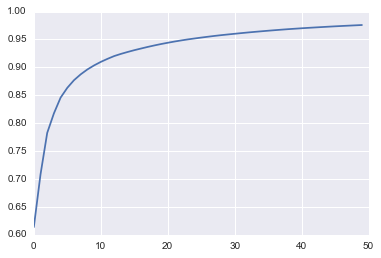

In [79]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

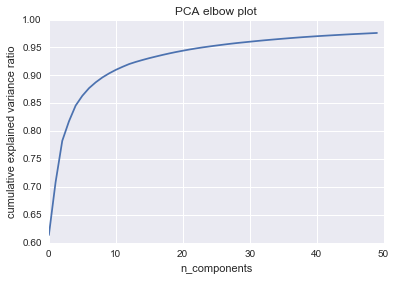

In [82]:
pca = PCA(n_components=50)
pca.fit(images)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA elbow plot")
plt.xlabel("n_components")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [87]:
np.arange(10,len(images)+10, 10)

array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
       1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
       1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
       1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
       1440, 1450, 1460, 1470, 1480, 1490, 1500, 15

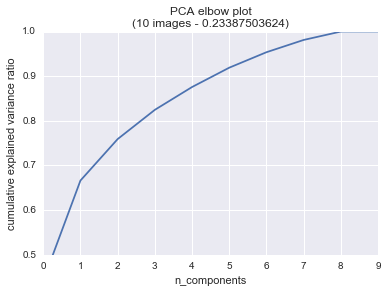

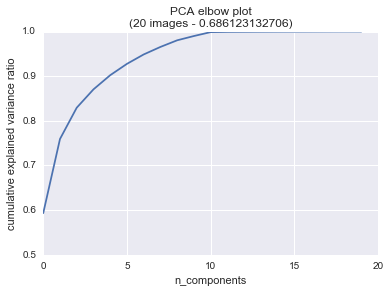

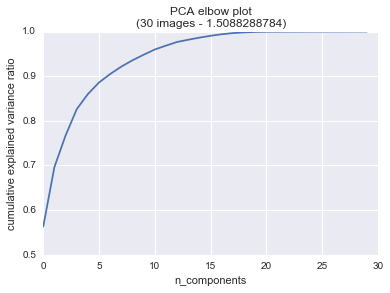

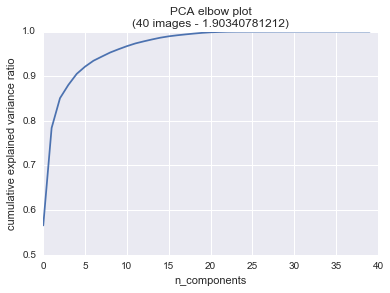

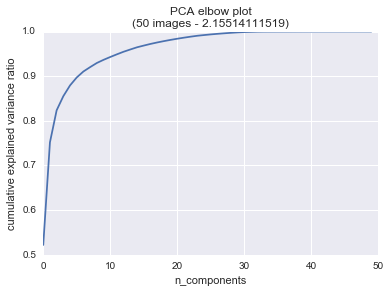

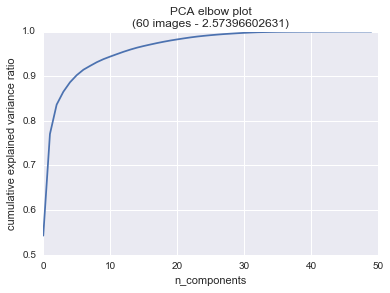

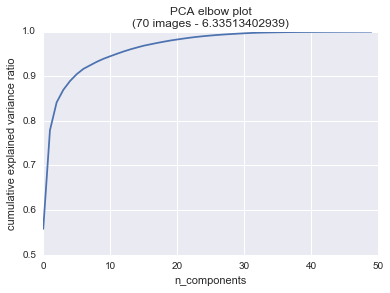

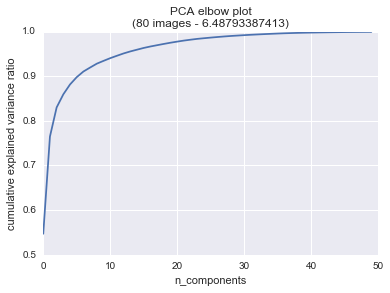

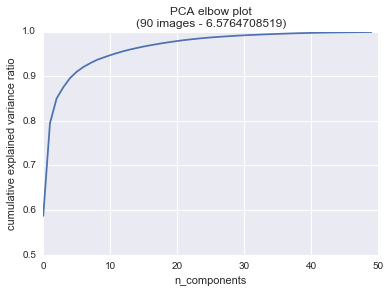

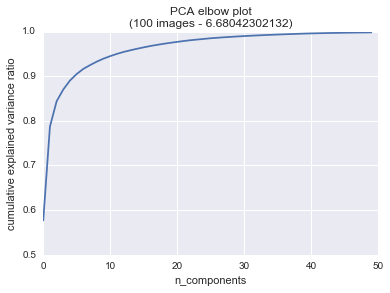

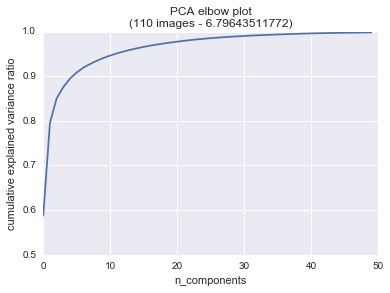

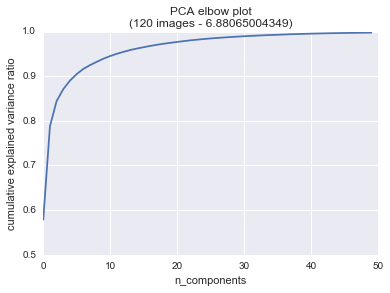

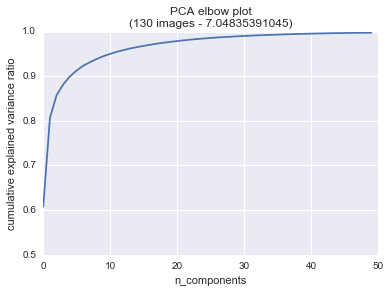

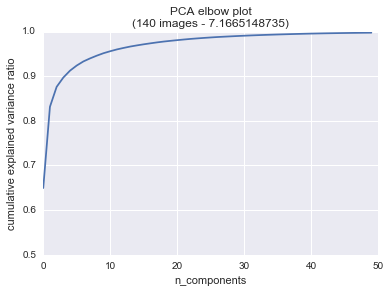

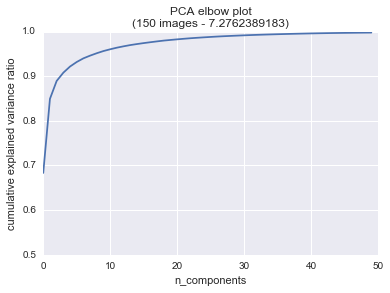

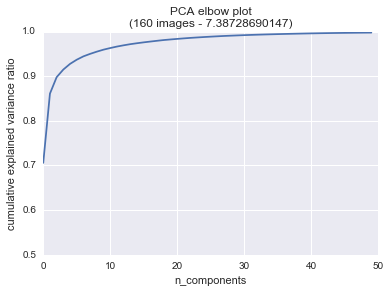

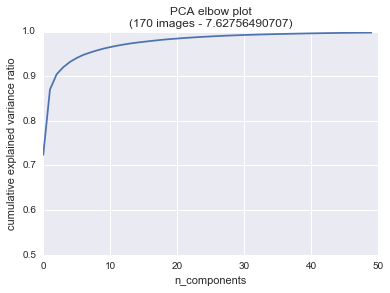

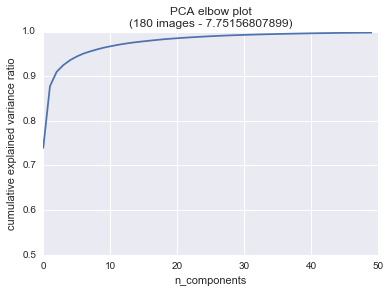

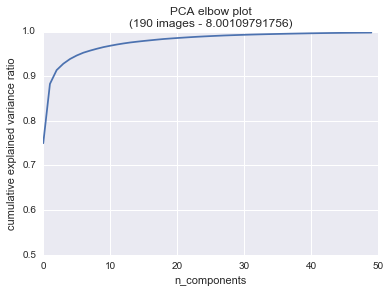

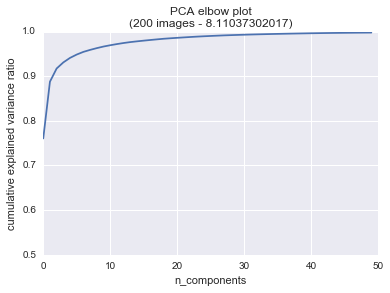

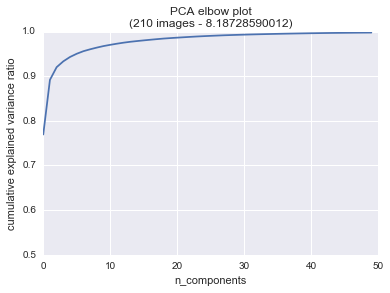

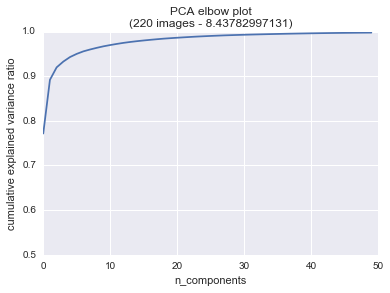

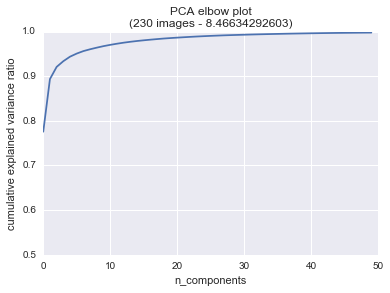

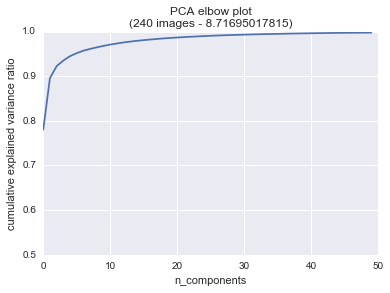

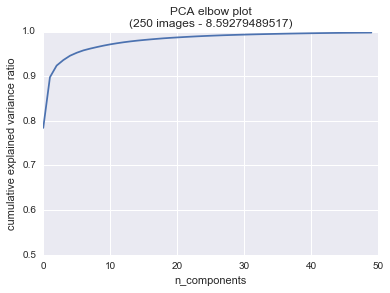

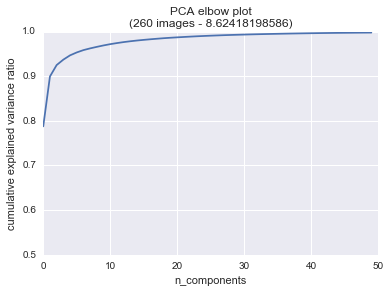

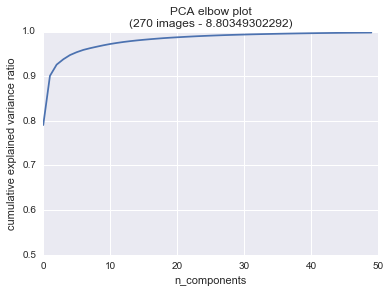

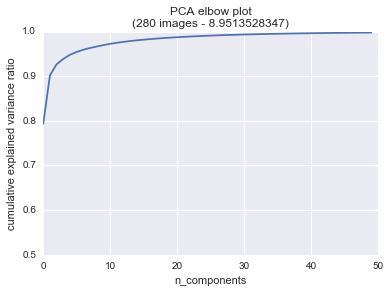

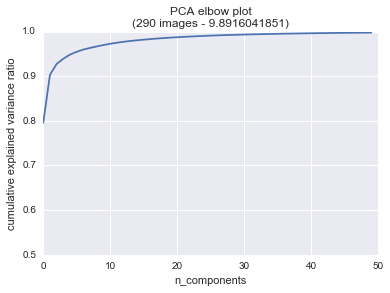

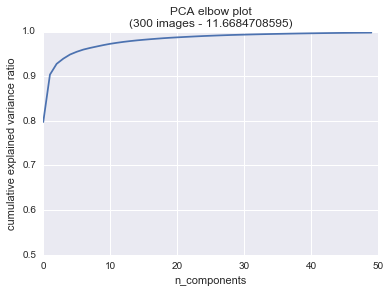

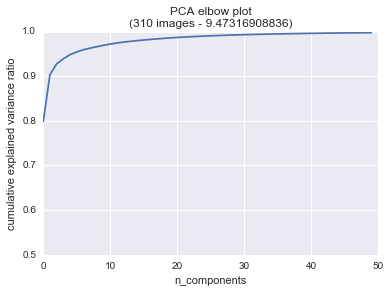

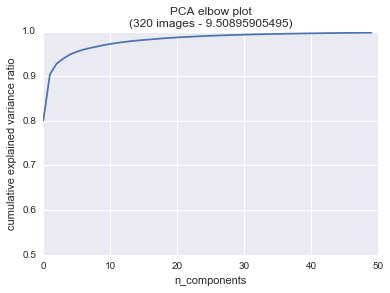

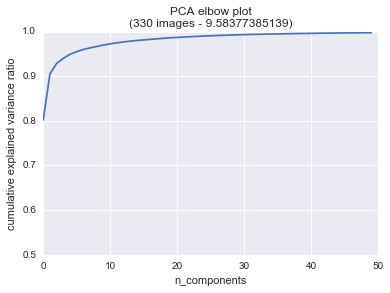

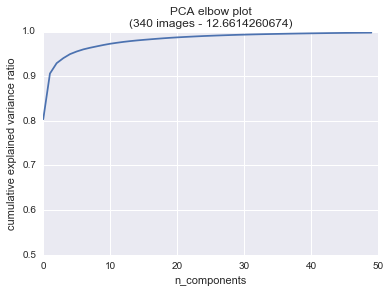

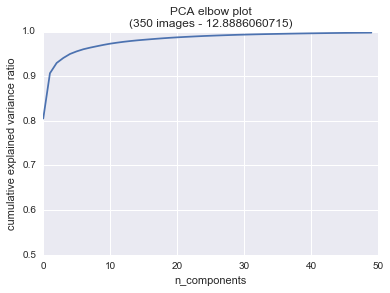

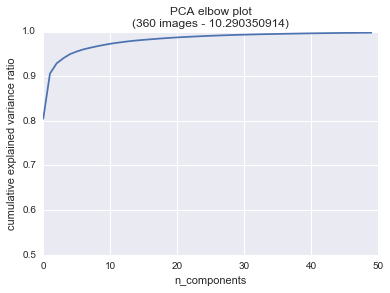

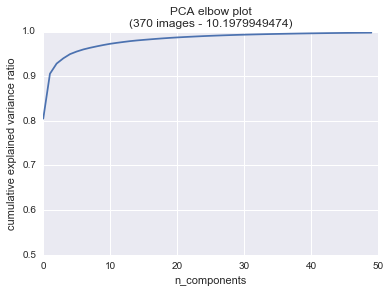

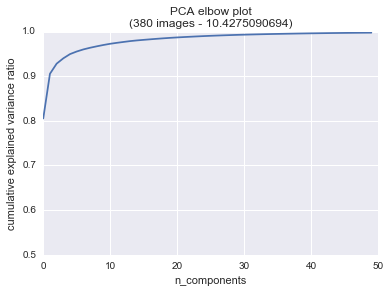

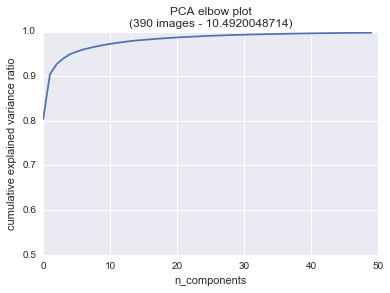

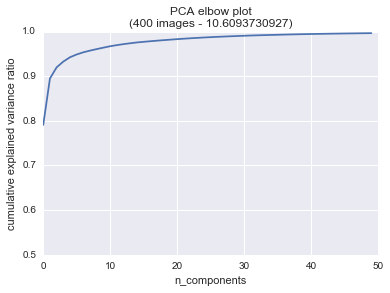

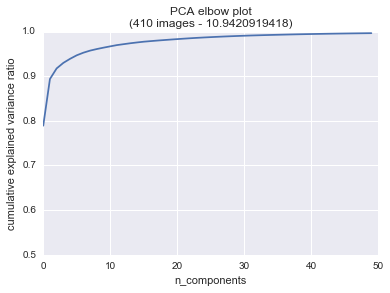

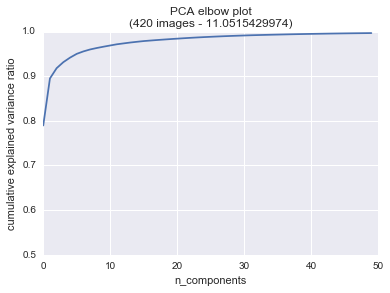

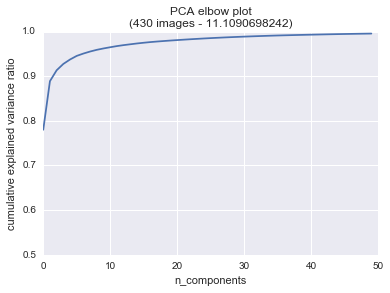

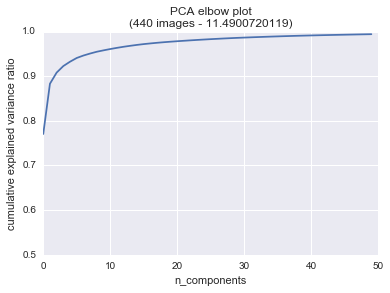

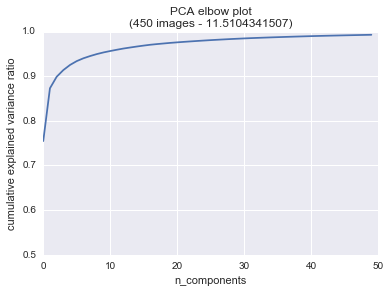

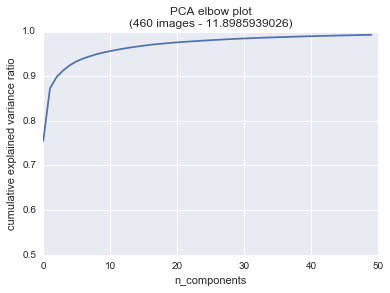

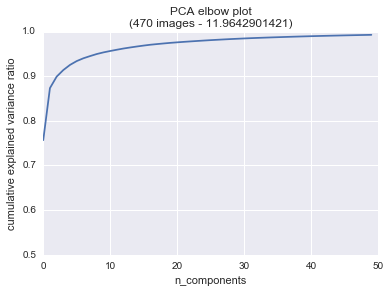

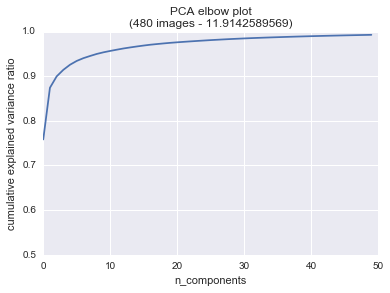

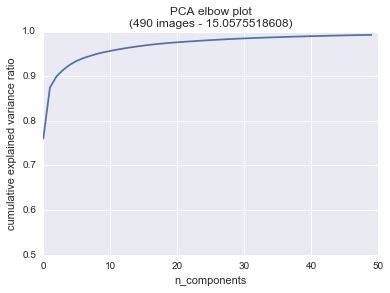

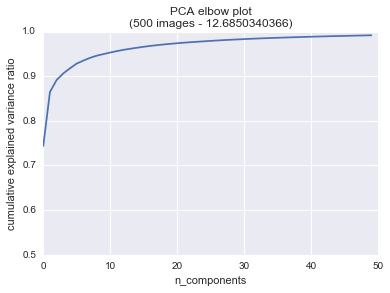

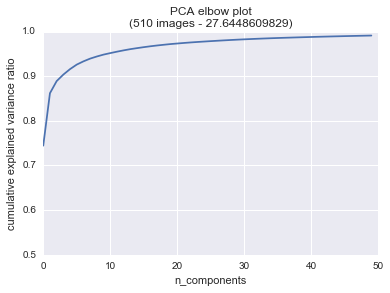

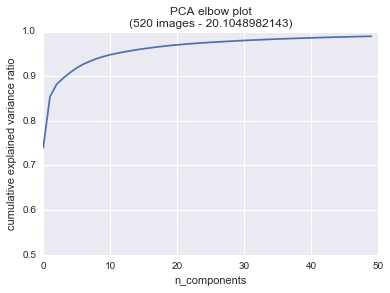

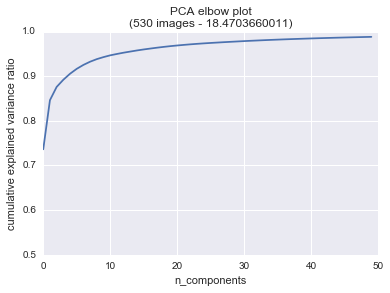

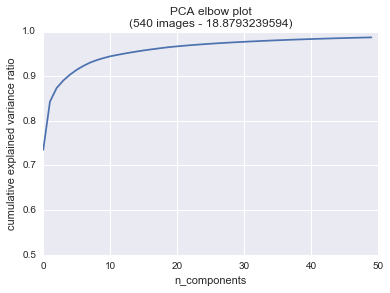

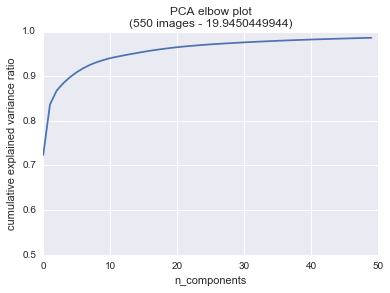

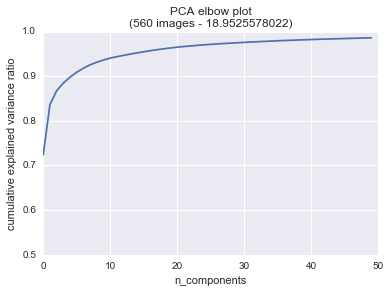

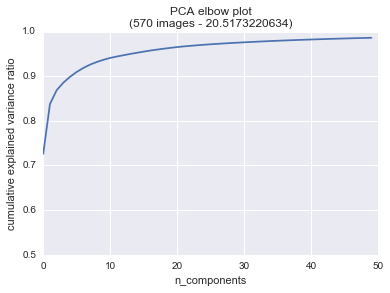

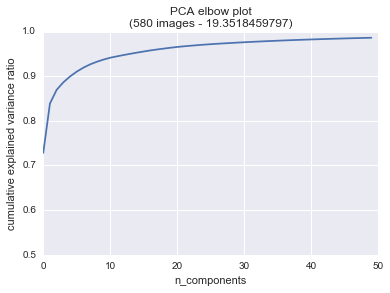

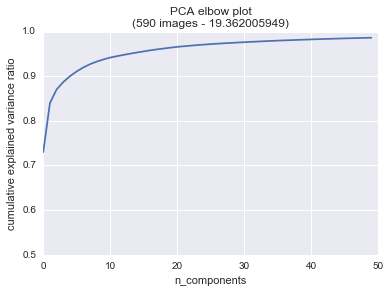

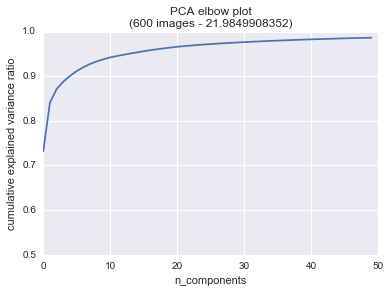

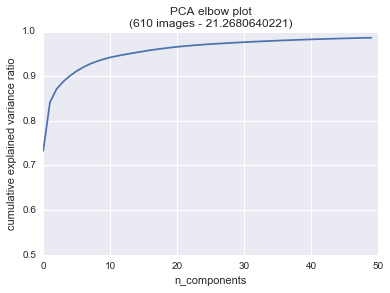

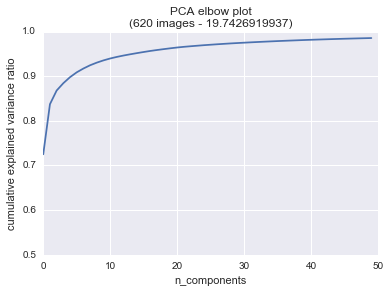

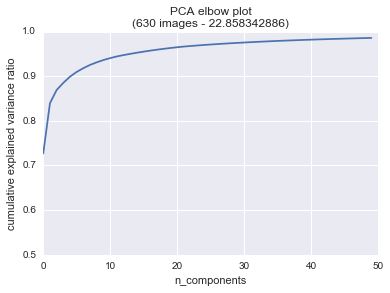

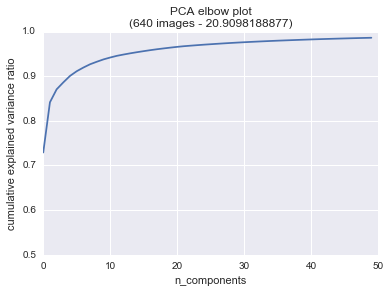

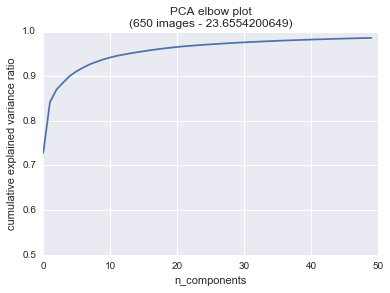

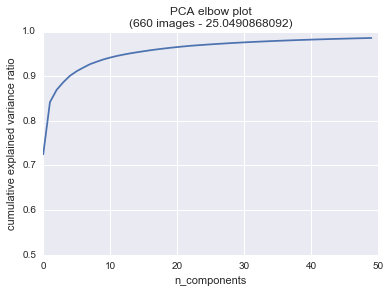

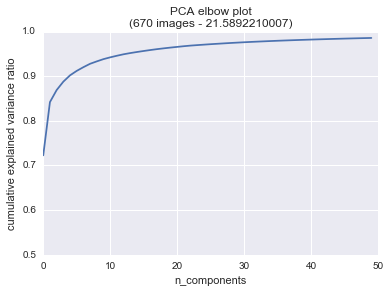

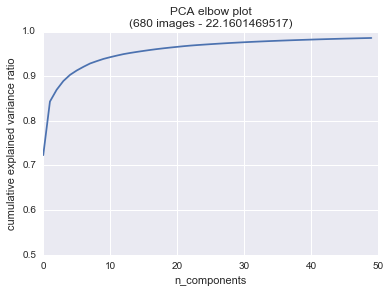

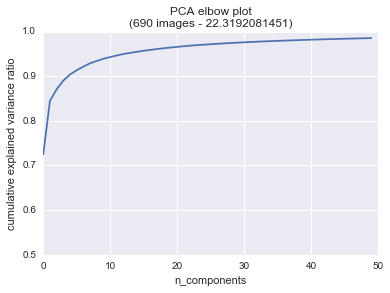

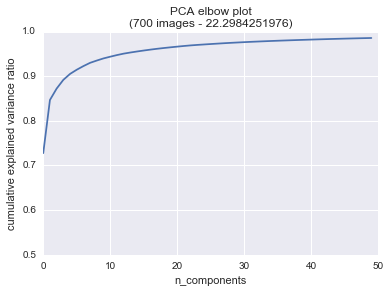

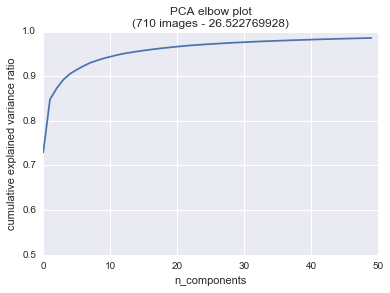

KeyboardInterrupt: 

In [96]:
images_counts = np.arange(10,len(images)+10, 10)
times = []
for num_images in images_counts:
    t1 = time.time()
    pca = PCA(n_components=50)
    pca.fit(images[0:num_images])
    t2 = time.time()
    times.append(t2-t1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title("PCA elbow plot\n("+str(num_images)+" images - "+str(t2-t1)+")")
    plt.xlabel("n_components")
    plt.ylim(0.5,1)
    plt.ylabel("cumulative explained variance ratio")
    plt.show()

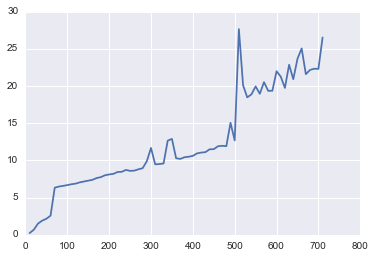

In [101]:
plt.plot(images_counts[0:len(times)], times)

In [103]:
images_counts[0:len(times)]

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260,
       270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390,
       400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520,
       530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650,
       660, 670, 680, 690, 700, 710])

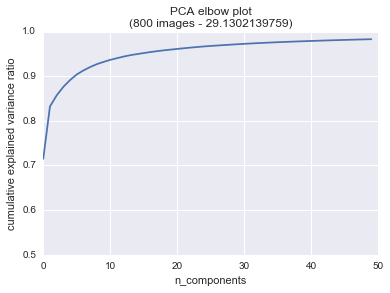

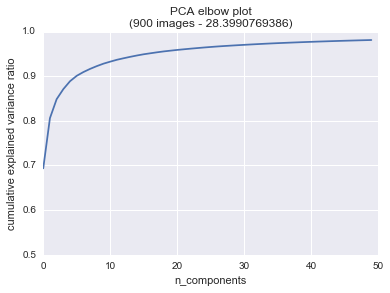

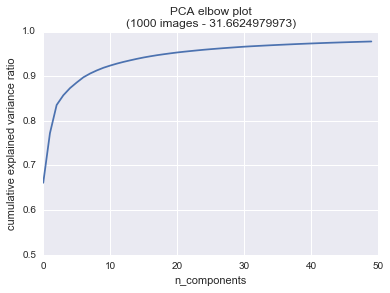

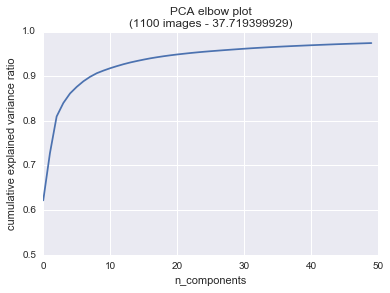

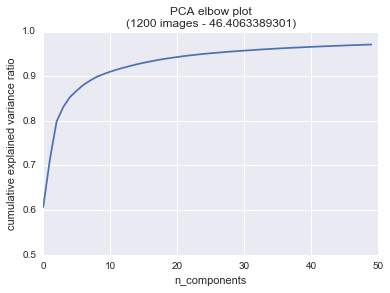

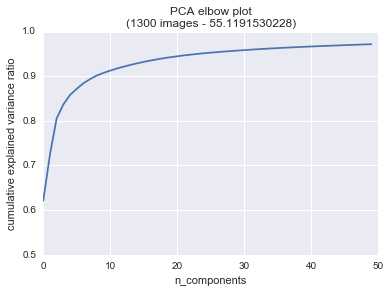

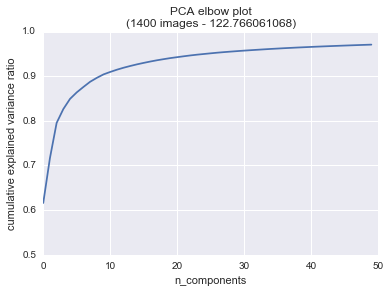

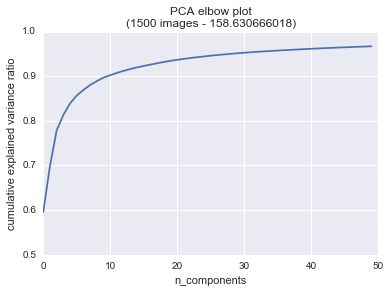

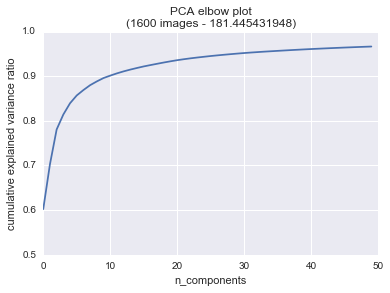

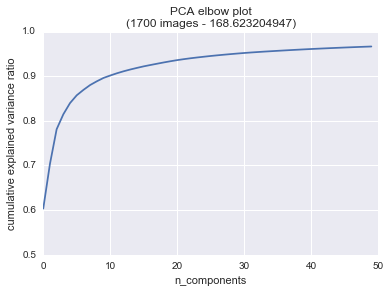

In [104]:
images_counts_100 = np.arange(800,len(images)+100, 100)
times_100 = []
for num_images in images_counts_100:
    t1 = time.time()
    pca = PCA(n_components=50)
    pca.fit(images[0:num_images])
    t2 = time.time()
    times_100.append(t2-t1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title("PCA elbow plot\n("+str(num_images)+" images - "+str(t2-t1)+")")
    plt.xlabel("n_components")
    plt.ylim(0.5,1)
    plt.ylabel("cumulative explained variance ratio")
    plt.show()

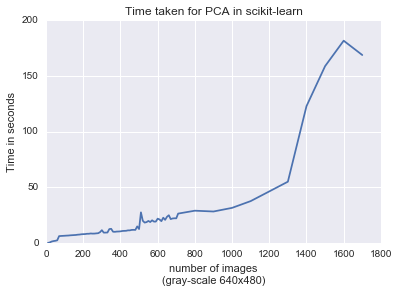

In [117]:
plt.plot(np.concatenate([images_counts[0:len(times)], images_counts_100]), np.concatenate([times,times_100]))
plt.title("Time taken for PCA in scikit-learn")
plt.xlabel('number of images\n(gray-scale 640x480)')
plt.ylabel('Time in seconds')
plt.show()

In [110]:
images_counts[0:len(times)] + images_counts_100

ValueError: operands could not be broadcast together with shapes (71,) (10,) 

In [113]:
np.concatenate([[1,2,3], [4,5,6]])

array([1, 2, 3, 4, 5, 6])

# Train on PCA data

In [155]:
df_closed = df[ df.is_open == 0]
df_open = df[ df.is_open == 1]
balanced_size = min(df_closed.shape[0], df_open.shape[0])
print balanced_size

df_closed = df_closed.sample(n=balanced_size, random_state=1)
df_open = df_open.sample(n=balanced_size, random_state=2)

df_balanced = pd.concat([df_open, df_closed], axis=0)

filenames_balanced = df_balanced.index.values.tolist()
filenames_balanced.sort(key=lambda filename: os.stat(filename).st_mtime)

df_balanced = df_balanced.ix[filenames_balanced]

sample_size = len(filenames_balanced)
cut_point = int(sample_size * 0.7)

df_balanced.head()

805


,file_size,is_open_guess,is_open_human,is_open
IR_images/01-20171007175835-00.jpg,27282,NaN,1,1
IR_images/01-20171007175836-00.jpg,32798,NaN,1,1
IR_images/01-20171007175837-00.jpg,34295,NaN,1,1
IR_images/01-20171007175838-00.jpg,33436,NaN,1,1
IR_images/01-20171007175839-00.jpg,31221,NaN,1,1


In [156]:
images = [np.reshape(np.asarray(Image.open(filename).convert('L')), (-1)) for filename in filenames_balanced]

In [157]:
X_pca = X[0:cut_point]

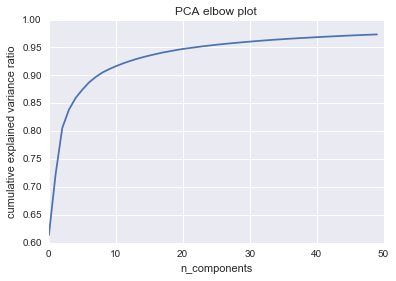

In [158]:
pca = PCA(n_components=50)
pca.fit(X_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA elbow plot")
plt.xlabel("n_components")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [159]:
vectors = pca.transform(images)

In [160]:
X = vectors
# y = df.is_open.astype(int)
y = df_balanced.is_open.astype(int)
X_train = X[0:cut_point]
X_test = X[cut_point:-1]
y_train = y[0:cut_point]
y_test = y[cut_point:-1]

In [163]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# clf = LogisticRegression()
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

[[311   0]
 [  0 171]]
[[805   0]
 [  0 805]]


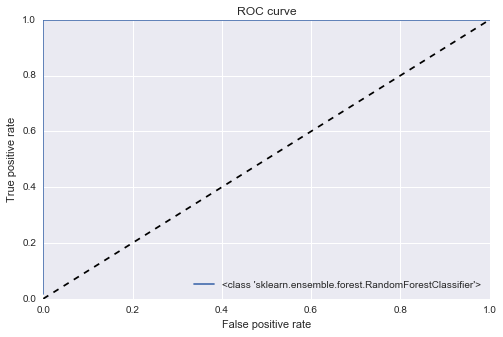

In [164]:
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X_test)
print confusion_matrix(y_test, y_pred)

y_pred = clf.predict(X)
print confusion_matrix(y, y_pred)

from sklearn.metrics import roc_curve
y_pred_rt = clf.predict_proba(X_test)[:, 1]
fpr_rt_lsvc, tpr_rt_lsvc, _ = roc_curve(y_test, y_pred_rt)

plt.figure(1, figsize=(8,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lsvc, tpr_rt_lsvc, label=str(type(clf)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

TypeError: Invalid dimensions for image data

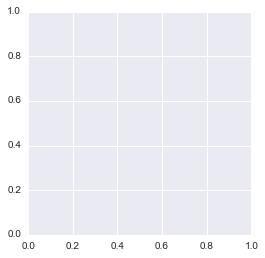

In [166]:
plt.imshow(np.reshape(vectors[0])

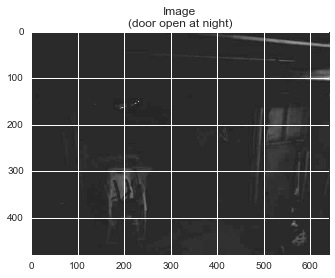

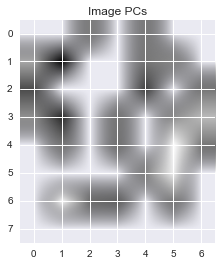

In [219]:
plt.title('Image\n(door open at night)')
plt.imshow(-1* np.reshape(images[200], (480,-1)))
plt.show()
plt.title('Image PCs')
plt.imshow(np.reshape(np.log(np.concatenate([vectors[200],[0,0,0,0,0,0]])), (8,-1)))
plt.show()


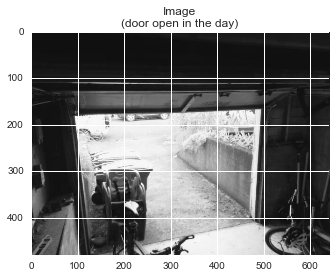

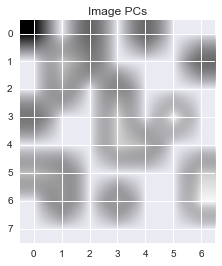

In [221]:
plt.title('Image\n(door open in the day)')
plt.imshow(-1*np.reshape(images[400], (480,-1)))
plt.show()
plt.title('Image PCs')
plt.imshow(np.reshape(np.log(np.concatenate([vectors[400],[0,0,0,0,0,0]])), (8,-1)))
plt.show()


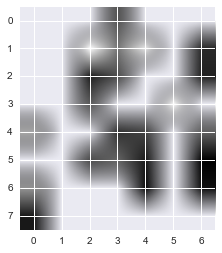

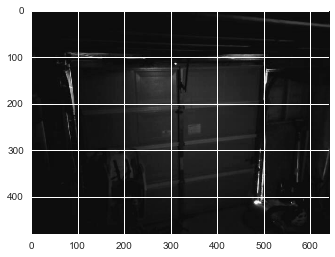

In [213]:
plt.imshow(np.reshape(np.log(np.concatenate([vectors[300],[0,0,0,0,0,0]])), (8,-1)))
plt.show()
plt.imshow(-1*np.reshape(images[300], (480,-1)))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ef8a250>]], dtype=object)

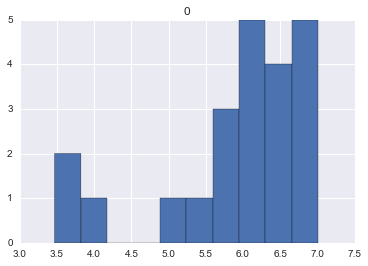

In [211]:
pd.DataFrame(np.log(vectors[300])).hist()

In [222]:
# Scan for the optimum number of PCs

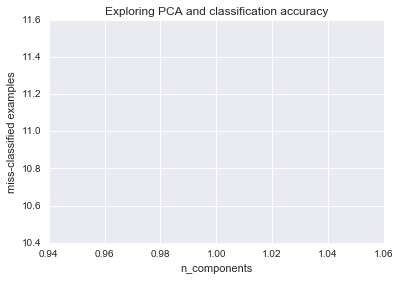

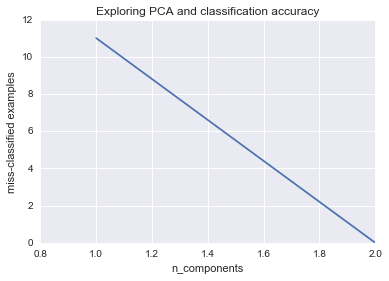

KeyboardInterrupt: 

In [230]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

miss_classifications = []

for n_components in np.arange(1,50+1,1):
    pca = PCA(n_components=n_components)
    pca.fit(images[0:cut_point])

    vectors = pca.transform(images)
    X = vectors
    y = df_balanced.is_open.astype(int)
    X_train = X[0:cut_point]
    X_test = X[cut_point:-1]
    y_train = y[0:cut_point]
    y_test = y[cut_point:-1]

    # clf = LogisticRegression()
    clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    miss_classification = confusion_matrix(y_test, y_pred)[0][1] + confusion_matrix(y_test, y_pred)[1][0]
    miss_classifications.append(miss_classification)
    
    plt.plot(np.arange(1,len(miss_classifications)+1, 1), miss_classifications)
    plt.title("Exploring PCA and classification accuracy")
    plt.xlabel("n_components")
    plt.ylabel("miss-classified examples")
    plt.show()
    

In [ ]:
from sklearn.decomposition import PCA
t1 = time.time()
pca = PCA(n_components=2)
pca.fit(images[0:cut_point])
vectors = pd.DataFrame(pca.transform(images))
t2 = time.time()
print (t2-t1),'(',(t2-t1)/len(filenames),')'

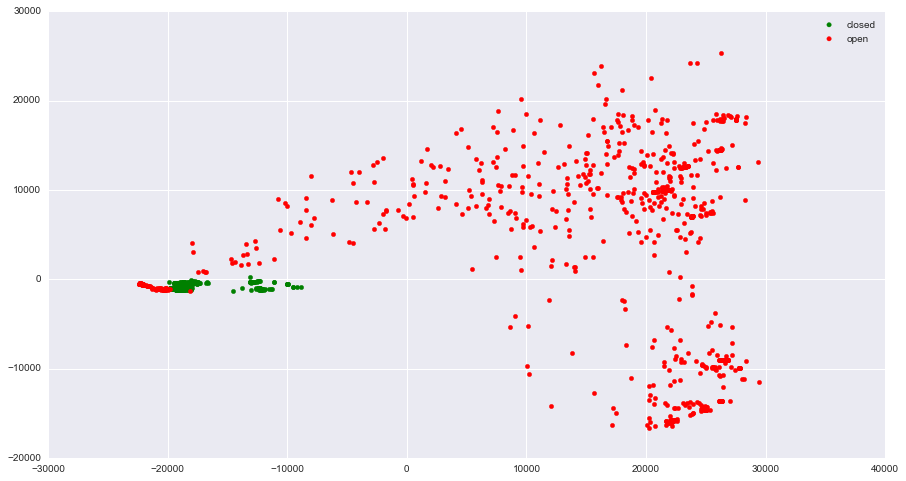

In [12]:
plt.figure(figsize=(15,8))
vectors_closed = vectors[ (df_balanced.is_open == 0).values ]
vectors_open = vectors[ (df_balanced.is_open == 1).values ]
plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
plt.legend()
plt.show()

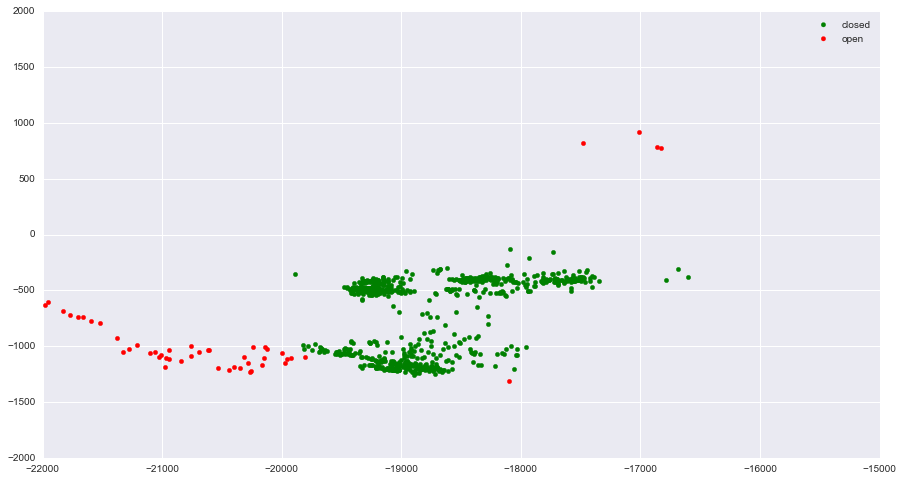

In [13]:
plt.figure(figsize=(15,8))
vectors_closed = vectors[ (df_balanced.is_open == 0).values ]
vectors_open = vectors[ (df_balanced.is_open == 1).values ]
plt.scatter(x=vectors_closed[0], y=vectors_closed[1], color='green', label='closed')
plt.scatter(x=vectors_open[0], y=vectors_open[1], color='red', label='open')
plt.legend()
plt.xlim(-22000,-15000)
plt.ylim(-2000,2000)
plt.show()